In [1]:
# ============================
# DATA LOADING & EXPLORATION
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier


# -------------------------
# Load dataset
# -------------------------
data_path = "/home/rithwik/AI_ML/17_Weeks_of_Projects/Week_4_Student_Performance/data/student_performance.csv"
df = pd.read_csv(data_path)
print(df.head())

# show FinalGrade for students who got 98+ on ExamScore
print("\nFinal Grade for Students with ExamScore >= 98:")
print(df[df['ExamScore'] >= 98]['FinalGrade'])

# show FinalGrade for students who got less than 50 on ExamScore
print("\nFinal Grade for Students with ExamScore < 50:")
print(df[df['ExamScore'] < 50]['FinalGrade'])

   StudyHours  Attendance  Resources  Extracurricular  Motivation  Internet  \
0          19          64          1                0           0         1   
1          19          64          1                0           0         1   
2          19          64          1                0           0         1   
3          19          64          1                1           0         1   
4          19          64          1                1           0         1   

   Gender  Age  LearningStyle  OnlineCourses  Discussions  \
0       0   19              2              8            1   
1       0   23              3             16            0   
2       0   28              1             19            0   
3       0   19              2              8            1   
4       0   23              3             16            0   

   AssignmentCompletion  ExamScore  EduTech  StressLevel  FinalGrade  
0                    59         40        0            1           3  
1               

Note: In this dataset, FinalGrade is encoded where 0 = highest grade and 3 = lowest grade. We will reverse this encoding later for more intuitive interpretation (higher numbers = better grades).

In [2]:

# -------------------------
# TARGET ENCODING
# -------------------------
target = "FinalGrade"
y = df[target]

# Encode target - reverse the scale so higher = better
# Original: 0 = highest, 1 = high, 2 = low, 3 = lowest
# After reversal: 3 = highest, 2 = high, 1 = low, 0 = lowest
y_encoded = 3 - y.values

print("Target encoding mapping:")
print("  Original grade 0 (highest) → encoded as:", 3)
print("  Original grade 1 (high) → encoded as:", 2)
print("  Original grade 2 (low) → encoded as:", 1)
print("  Original grade 3 (lowest) → encoded as:", 0)

Target encoding mapping:
  Original grade 0 (highest) → encoded as: 3
  Original grade 1 (high) → encoded as: 2
  Original grade 2 (low) → encoded as: 1
  Original grade 3 (lowest) → encoded as: 0


In [3]:

# -------------------------
# FEATURE ENGINEERING
# -------------------------


# Transformations

df["LowAttendance"] = (df["Attendance"] < 75).astype(int)


df["OnlineCourses_norm"] = df["OnlineCourses"] / df["OnlineCourses"].max()

df["EngagementCount"] = (
    df["Extracurricular"] +
    df["Internet"] +
    df["OnlineCourses_norm"]
)




In [4]:

# -------------------------
# FEATURE CATEGORIZATION
# -------------------------

continuous_features = [
    "StudyHours",
    "Attendance",
    "Age",
    "OnlineCourses",
    "AssignmentCompletion",
    # "ExamScore"   # Excluded to avoid leakage
]

ordinal_features = ["Resources", "Motivation", "StressLevel"]
nominal_features = ["LearningStyle"]
binary_features = ["Extracurricular", "Internet", "Gender", "Discussions", "EduTech"]

all_features = continuous_features + ordinal_features + nominal_features + binary_features + ["LowAttendance", "EngagementCount"]

In [5]:

# ============================
# PREPROCESSING PIPELINE
# ============================

# Continuous → impute (though no missing values) + scale
continuous_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Ordinal → keep numeric codes as-is (no scaling to preserve ordinal relationships)

# Nominal categorical → impute + one-hot encode
nominal_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Binary → passthrough (no missing values, already encoded)

# Add engineered + ordinal + binary passthrough
preprocessor = ColumnTransformer(
    transformers=[
        ("cont", continuous_transformer, continuous_features),
        ("nom", nominal_transformer, nominal_features),
        ("ord", "passthrough", ordinal_features),
        ("bin", "passthrough", binary_features),
        ("eng", "passthrough", ["LowAttendance", "OnlineCourses_norm", "EngagementCount"])
    ]
)


In [6]:

# -------------------------
# Helper function to get feature names after transformation
# -------------------------
def get_feature_names(preprocessor, continuous_features, ordinal_features, 
                     nominal_features, binary_features):
    """Extract feature names after preprocessing transformation."""
    feature_names = []
    
    # Continuous features (names unchanged)
    feature_names.extend(continuous_features)
    
    # Ordinal features (names unchanged)
    feature_names.extend(ordinal_features)
    
    # Nominal features (get one-hot encoded names)
    nom_transformer = preprocessor.named_transformers_['nom']
    if hasattr(nom_transformer.named_steps['onehot'], 'get_feature_names_out'):
        feature_names.extend(
            nom_transformer.named_steps['onehot'].get_feature_names_out(nominal_features)
        )
    
    # Binary features (names unchanged)
    feature_names.extend(binary_features)
    
    return feature_names


In [7]:

# -------------------------
# TRAIN/TEST SPLIT 
# -------------------------
X = df.drop(columns=[target, "ExamScore"])  # Exclude ExamScore to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Fit the preprocessor
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Get feature names for interpretability
feature_names = preprocessor.get_feature_names_out()

print("\n✅ Preprocessing complete!")
print(f"Train shape: {X_train_prep.shape}")
print(f"Test shape: {X_test_prep.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nFeature names: {feature_names}")
print(f"\nTarget distribution (encoded):")
print(f"  Train: {np.bincount(y_train.astype(int))}")
print(f"  Test: {np.bincount(y_test.astype(int))}")


✅ Preprocessing complete!
Train shape: (11202, 20)
Test shape: (2801, 20)
Number of features: 20

Feature names: ['cont__StudyHours' 'cont__Attendance' 'cont__Age' 'cont__OnlineCourses'
 'cont__AssignmentCompletion' 'nom__LearningStyle_0'
 'nom__LearningStyle_1' 'nom__LearningStyle_2' 'nom__LearningStyle_3'
 'ord__Resources' 'ord__Motivation' 'ord__StressLevel'
 'bin__Extracurricular' 'bin__Internet' 'bin__Gender' 'bin__Discussions'
 'bin__EduTech' 'eng__LowAttendance' 'eng__OnlineCourses_norm'
 'eng__EngagementCount']

Target distribution (encoded):
  Train: [2594 2894 2648 3066]
  Test: [649 724 662 766]



Explained variance ratio (first 3 comps): [0.13495765 0.13093703 0.11136789]
Total explained variance (3 comps): 0.3772625732305933


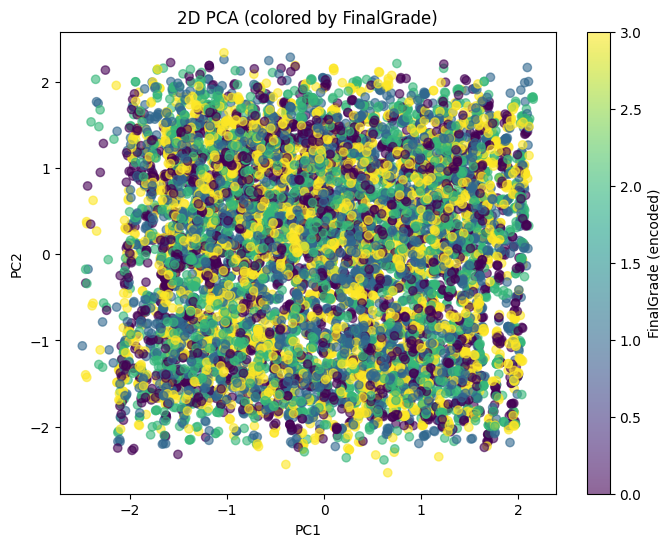

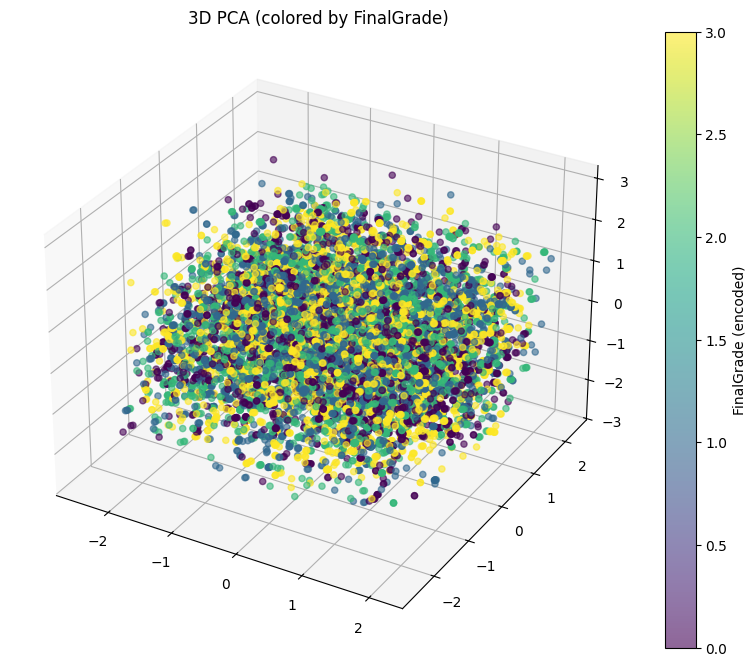

/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


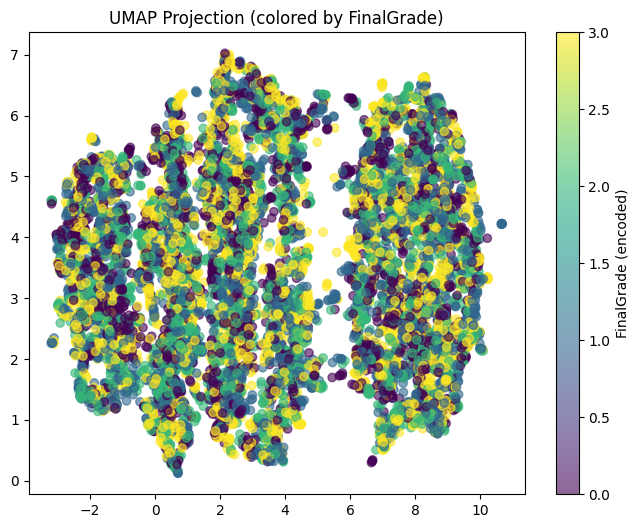

In [8]:
# -------------------------
# DIMENSIONALITY REDUCTION & VISUALIZATION
# -------------------------
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# PCA (2D and 3D)
pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train_prep)

print("\nExplained variance ratio (first 3 comps):", pca.explained_variance_ratio_)
print("Total explained variance (3 comps):", pca.explained_variance_ratio_.sum())

# 2D PCA plot (colored by FinalGrade)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap="viridis", alpha=0.6)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("2D PCA (colored by FinalGrade)")
plt.colorbar(scatter, label="FinalGrade (encoded)")
plt.show()

# 3D PCA plot (colored by FinalGrade)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], 
               c=y_train, cmap="viridis", alpha=0.6)
ax.set_title("3D PCA (colored by FinalGrade)")
fig.colorbar(p, label="FinalGrade (encoded)")
plt.show()

# UMAP (2D)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_train_umap = umap_model.fit_transform(X_train_prep)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=y_train, cmap="viridis", alpha=0.6)
plt.title("UMAP Projection (colored by FinalGrade)")
plt.colorbar(scatter, label="FinalGrade (encoded)")
plt.show()



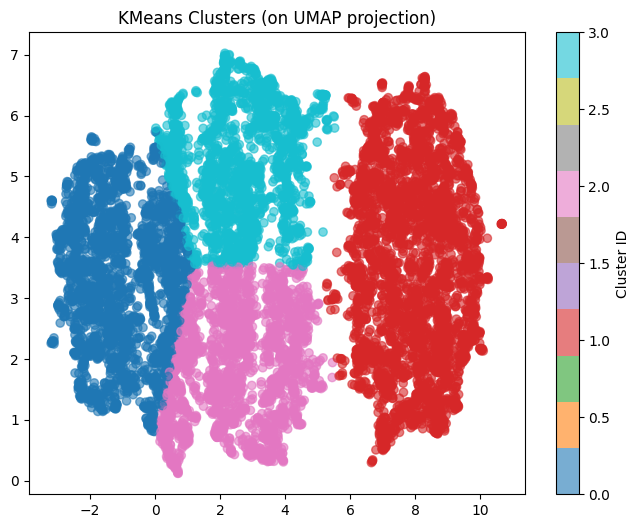

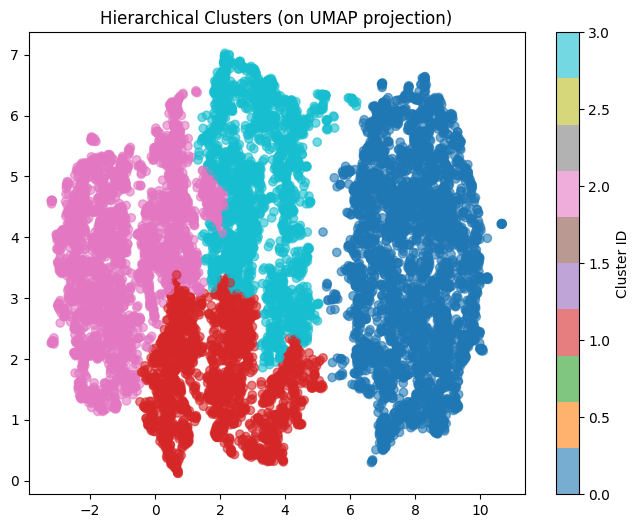

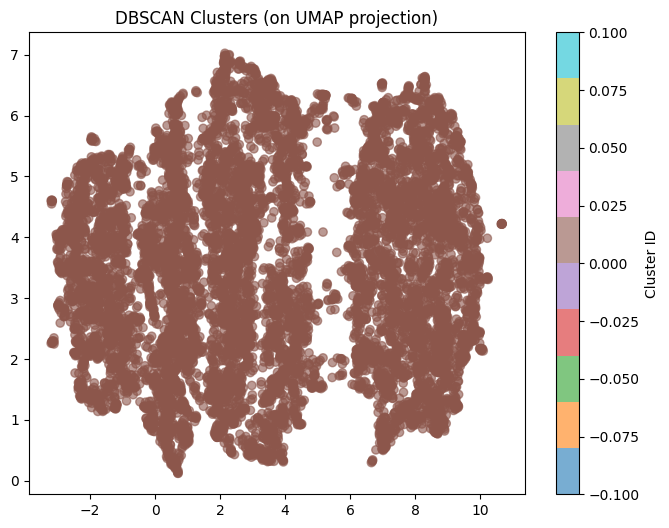

In [9]:

# -------------------------
# CLUSTERING
# -------------------------
cluster_results = {}

# K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_results["KMeans"] = kmeans.fit_predict(X_train_umap)

# Hierarchical (Agglomerative)
agg = AgglomerativeClustering(n_clusters=4)
cluster_results["Hierarchical"] = agg.fit_predict(X_train_umap)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
cluster_results["DBSCAN"] = dbscan.fit_predict(X_train_umap)

# Visualize clusters in UMAP space
for method, labels in cluster_results.items():
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=labels, cmap="tab10", alpha=0.6)
    plt.title(f"{method} Clusters (on UMAP projection)")
    plt.colorbar(scatter, label="Cluster ID")
    plt.show()


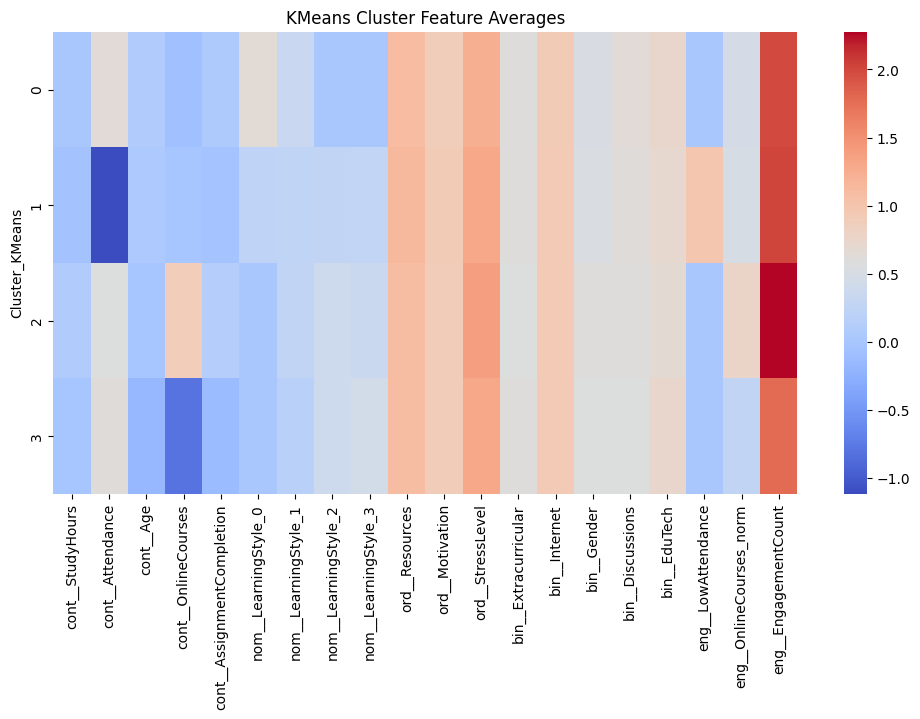

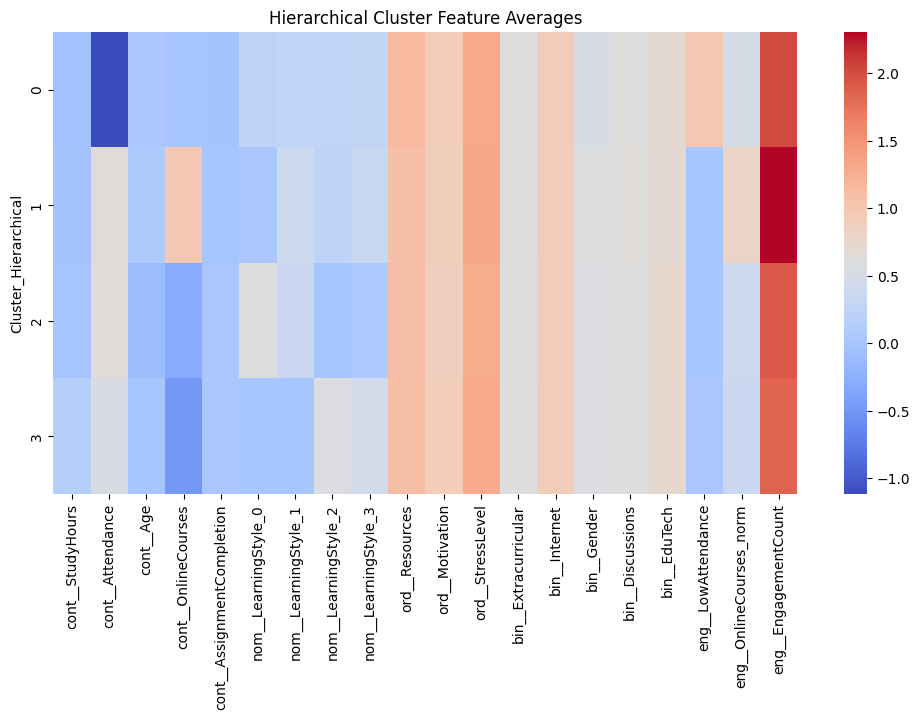

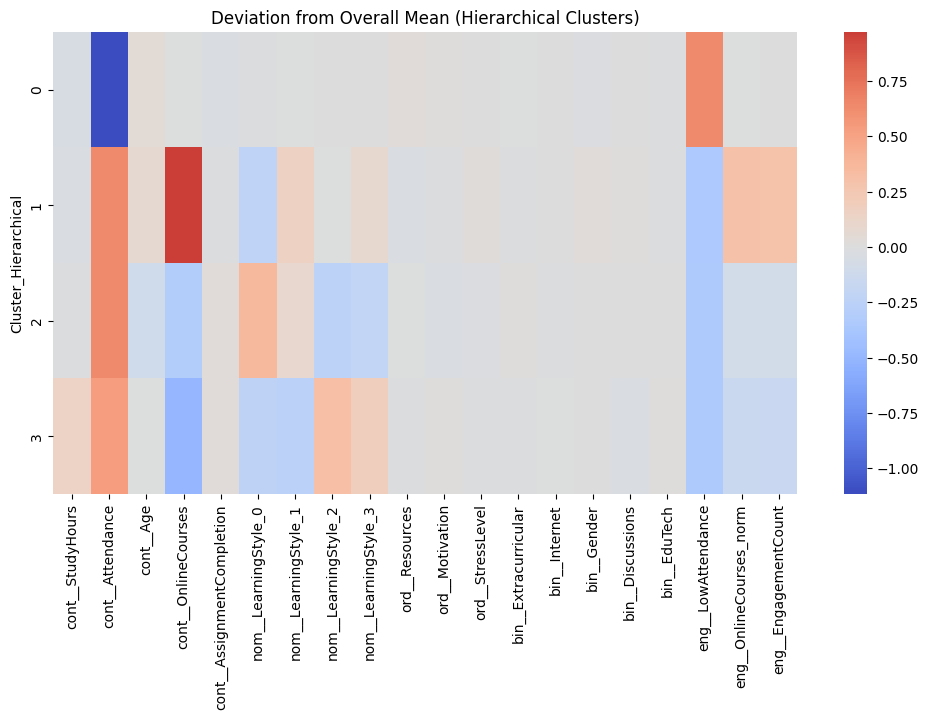


=== Hierarchical Cluster Means ===
                      cont__StudyHours  cont__Attendance  cont__Age  \
Cluster_Hierarchical                                                  
0                                -0.05             -1.12       0.05   
1                                -0.04              0.64       0.07   
2                                -0.01              0.65      -0.11   
3                                 0.14              0.54      -0.01   

                      cont__OnlineCourses  cont__AssignmentCompletion  \
Cluster_Hierarchical                                                    
0                                   -0.00                       -0.03   
1                                    0.97                       -0.01   
2                                   -0.31                        0.03   
3                                   -0.50                        0.03   

                      nom__LearningStyle_0  nom__LearningStyle_1  \
Cluster_Hierarchical          

In [10]:


# -------------------------
# CLUSTERING ANALYSIS - INTERPRETATION
# -------------------------
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Put results in dataframe for analysis
df_clusters = pd.DataFrame(X_train_prep, columns=feature_names)
df_clusters["FinalGrade"] = y_train
for method, labels in cluster_results.items():
    df_clusters[f"Cluster_{method}"] = labels

# Feature averages per cluster (KMeans)
cluster_Kmeans = df_clusters.groupby("Cluster_KMeans")[feature_names].mean()
plt.figure(figsize=(12,6))
sns.heatmap(cluster_Kmeans, cmap="coolwarm", annot=False, cbar=True)
plt.title("KMeans Cluster Feature Averages")
plt.show()

# Feature averages per cluster (Hierarchical)
cluster_hier = df_clusters.groupby("Cluster_Hierarchical")[feature_names].mean()
plt.figure(figsize=(12,6))
sns.heatmap(cluster_hier, cmap="coolwarm", annot=False, cbar=True)
plt.title("Hierarchical Cluster Feature Averages")
plt.show()

# Compare hierarchical cluster centers vs overall mean
overall_means = df_clusters[feature_names].mean()
deviation = cluster_hier - overall_means
plt.figure(figsize=(12,6))
sns.heatmap(deviation, cmap="coolwarm", center=0, annot=False, cbar=True)
plt.title("Deviation from Overall Mean (Hierarchical Clusters)")
plt.show()


# ---- NEW: Export tables for inspection ----
# Show cluster means and deviation in tables
print("\n=== Hierarchical Cluster Means ===")
print(cluster_hier.round(2))

print("\n=== Deviation from Overall Mean (Hierarchical Clusters) ===")
print(deviation.round(2))



# Cross-tab cluster with FinalGrade
print("\nCluster vs FinalGrade (Hierarchical):")
print(pd.crosstab(df_clusters["Cluster_Hierarchical"], df_clusters["FinalGrade"]))


# 🎓 Student Cluster Persona Analysis

## 📊 Cluster 0: The Independent Achievers (3,965 students)

**Grade Distribution:** Fail: 22.1% | Pass: 27.2% | Good: 22.8% | **Excellent: 27.9%** (highest)

**Key Traits:**
- 📉 **Much lower attendance** (-1.12) despite average study hours
- 💻 High attendance issues `eng_LowAttendance` (+0.64)
- 🎯 Slightly older (+0.05)

**Persona:** A paradoxical group that achieves top grades (27.9% excellent) despite poor attendance, suggesting strong **independent learning strategies**. However, equally high pass rates (27.2%) show inconsistency — some thrive autonomously while others barely scrape by without classroom structure.

---

## ✅ Cluster 1: The Structured Learners (2,079 students)

**Grade Distribution:** Fail: 21.7% | Pass: 25.8% | Good: 26.5% | Excellent: 26.0% (balanced)

**Key Traits:**
- ✅ **Higher attendance** (+0.64)
- 📱 **Very high online course engagement** (+0.97)
- 💡 Lower attendance issues (-0.35), higher engagement (+0.29)

**Persona:** The most **consistent performers** with balanced outcomes across all levels (52.5% good/excellent combined). They show up regularly, leverage all available resources, and succeed through **discipline and routine** rather than exceptional talent.

---

## ⚠️ Cluster 2: The Inconsistent Performers (2,960 students)

**Grade Distribution:** **Fail: 25.3%** (highest) | Pass: 24.9% | Good: 23.0% | Excellent: 26.8%

**Key Traits:**
- 📊 **Above-average attendance** (+0.65) but polarized outcomes
- 📉 **Lower online course usage** (-0.31)
- ⚖️ Lower motivation and stress management
- 💻 Reduced engagement (-0.09)

**Persona:** **Wasted potential** — they attend class but don't fully engage. High failure rates despite good attendance suggest physical presence without mental engagement. This group needs interventions focused on **active learning strategies** to translate attendance into performance.

---

## 🎯 Cluster 3: The Dedicated Traditionalists (2,207 students)

**Grade Distribution:** Fail: 23.5% | Pass: 24.8% | Good: 23.3% (lowest) | **Excellent: 28.4%** (highest overall)

**Key Traits:**
- 📈 **Higher study hours** (+0.14) and attendance (+0.54)
- 📉 **Lower online course usage** (-0.50)
- 🧠 Preference for LearningStyle_2 and LearningStyle_3

**Persona:** The **classic hardworking student** achieving the best outcomes through traditional methods. They excel via persistence, focus, and consistent study habits without heavy digital tool reliance. Proves that **fundamentals still matter** — disciplined effort and traditional approaches remain highly effective.

---

## 🔑 Key Insights

- **Attendance ≠ success**: Cluster 0 shows low attendance can still yield excellence with self-study
- **Consistency wins**: Cluster 1's regular habits create stable outcomes
- **Engagement > presence**: Cluster 2's polarized results highlight the importance of active learning
- **Traditional methods work**: Cluster 3 proves focus and discipline trump tech engagement


🔹 Logistic Regression Results
Accuracy: 0.2756
Weighted F1: 0.2723
Mean Abs Error (ordinal): 1.2342

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.36      0.31       649
           1       0.29      0.19      0.23       724
           2       0.25      0.26      0.26       662
           3       0.29      0.30      0.29       766

    accuracy                           0.28      2801
   macro avg       0.28      0.28      0.27      2801
weighted avg       0.28      0.28      0.27      2801



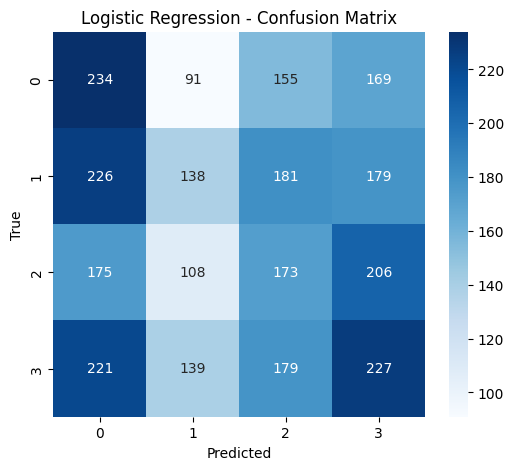


🔹 Random Forest Results
Accuracy: 0.9179
Weighted F1: 0.9178
Mean Abs Error (ordinal): 0.1407

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       649
           1       0.91      0.94      0.92       724
           2       0.94      0.90      0.92       662
           3       0.91      0.94      0.92       766

    accuracy                           0.92      2801
   macro avg       0.92      0.92      0.92      2801
weighted avg       0.92      0.92      0.92      2801



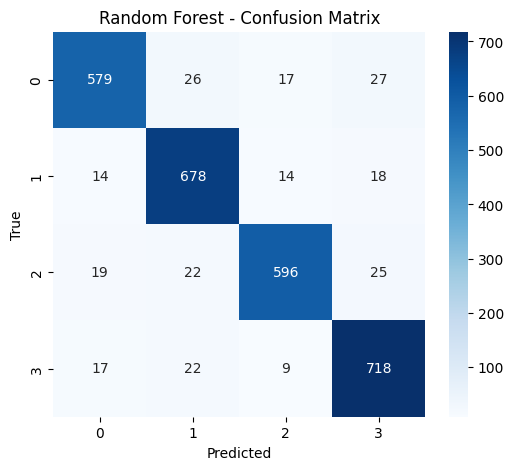

/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:36:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Results
Accuracy: 0.8554
Weighted F1: 0.8554
Mean Abs Error (ordinal): 0.2417

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       649
           1       0.83      0.88      0.85       724
           2       0.86      0.85      0.86       662
           3       0.86      0.87      0.86       766

    accuracy                           0.86      2801
   macro avg       0.86      0.85      0.86      2801
weighted avg       0.86      0.86      0.86      2801



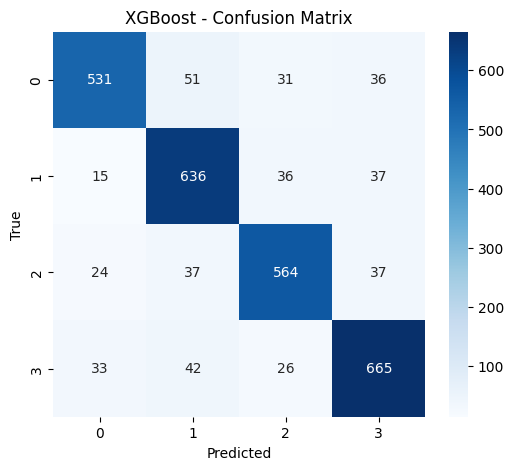

In [11]:

# ============================
# BASELINE MODEL TRAINING & EVALUATION
# ============================


# -------------------------
# Helper function: evaluate model
# -------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Fit
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Standard classification metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")  # weighted for imbalance
    
    # Ordinal-friendly metric: Mean Absolute Error (on grade distance)
    mae = np.mean(np.abs(y_test - y_pred))
    
    print(f"\n🔹 {model_name} Results")
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1: {f1:.4f}")
    print(f"Mean Abs Error (ordinal): {mae:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return model

# -------------------------
# Baseline Models
# -------------------------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
xgb = XGBClassifier(
    objective="multi:softmax",  # directly outputs class labels
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)

# Train + Evaluate
log_reg_model = evaluate_model(log_reg, X_train_prep, y_train, X_test_prep, y_test, "Logistic Regression")
rf_model = evaluate_model(rf, X_train_prep, y_train, X_test_prep, y_test, "Random Forest")
xgb_model = evaluate_model(xgb, X_train_prep, y_train, X_test_prep, y_test, "XGBoost")


## Baseline Predictive Models – Results

We trained three baseline classifiers (Logistic Regression, Random Forest, XGBoost) on the preprocessed dataset.  
Evaluation metrics include **Accuracy, Weighted F1-score, Mean Absolute Error (ordinal-aware),** and the full classification report.

---

### 📊 Logistic Regression
- **Accuracy:** 0.2756  
- **Weighted F1:** 0.2723  
- **Mean Absolute Error (ordinal):** 1.2342  

Performance is weak — the model struggles to capture signal, with predictions close to random guessing.

---

### 🌲 Random Forest
- **Accuracy:** 0.9179  
- **Weighted F1:** 0.9178  
- **Mean Absolute Error (ordinal):** 0.1407  

Strong performance with balanced precision/recall across all classes. Very low MAE indicates predictions are rarely far from the true grade.

---

### ⚡ XGBoost
- **Accuracy:** 0.8554  
- **Weighted F1:** 0.8554  
- **Mean Absolute Error (ordinal):** 0.2417  

Slightly below Random Forest but still strong. Handles all classes consistently, though with a bit more grade-level misclassification compared to RF.

---

## ✅ Key Takeaways
- Logistic Regression serves as a weak baseline, confirming this is a **non-linear, complex dataset**.  
- Random Forest performs best here, with very high accuracy and lowest ordinal error.  
- XGBoost is competitive but slightly behind RF on this dataset.  
- Both tree-based models capture the ordinal nature of **FinalGrade** much better than linear models.

In [12]:
# ============================
# HYPERPARAMETER TUNING (RandomizedSearchCV, GPU-enabled for XGBoost)
# ============================

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# -------------------------
# Stratified K-Fold (k=5)
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# Random Forest Randomized Search
# -------------------------
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=50,                  # sample 50 random combinations
    scoring="f1_weighted",
    cv=cv,
    verbose=0,                  # clean output
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)
print("Random Forest Best Params:", rf_search.best_params_)
print("Random Forest Best Weighted F1:", rf_search.best_score_)

# -------------------------
# XGBoost Randomized Search (GPU)
# -------------------------
xgb_model = xgb.XGBClassifier(
    tree_method="hist",  # GPU-friendly histogram algorithm
    device=0           # use CUDA device 0
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb_param_grid = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,                  # sample 50 random combinations
    scoring="f1_weighted",
    cv=cv,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
print("XGBoost Best Params:", xgb_search.best_params_)
print("XGBoost Best Weighted F1:", xgb_search.best_score_)


Random Forest Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Random Forest Best Weighted F1: 0.8853183386447021


/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:37:22] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:37:22] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:37:23] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:37:23] WARNING: 

XGBoost Best Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.85}
XGBoost Best Weighted F1: 0.8793995320851945


In [13]:
# ==========================
# ORDINAL-AWARE MODELING
# ==========================

# --------------------------
# Import necessary libraries
# --------------------------

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold

# Ordinal Logistic Regression library
!pip install mord --quiet
import mord as m

# If using XGBoost for ordinal regression later
import xgboost as xgb


# Ordinal Logistic Regression library
!pip install mord --quiet
import mord as m

# When using XGBoost for ordinal regression later
import xgboost as xgb

# --------------------------
# Prepare feature & target matrices
# --------------------------
# Assuming your preprocessed X_train, X_test, y_train, y_test exist from previous steps
# X_train, X_test: preprocessed feature matrices
# y_train, y_test: FinalGrade (ordinal: 0,1,2,3)

# --------------------------
# Ordinal Logistic Regression (mord)
# --------------------------
# Create and fit model
ordinal_model = m.LogisticAT(alpha=1.0)  # alpha: regularization strength
ordinal_model.fit(X_train, y_train)

# Predict
y_pred = ordinal_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Ordinal Logistic Regression Results")
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --------------------------
# Ordinal-aware XGBoost (pseudo)
# --------------------------
# Approximate ordinal awareness by treating grades as numeric for regression
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # treats target as numeric
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and round to nearest integer (0-3)
y_pred_xgb = np.clip(np.round(xgb_model.predict(X_test)), 0, 3)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("\nOrdinal-aware XGBoost Results")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# --------------------------
# Compare to baseline models
# --------------------------
# You already have baseline metrics from Sections 11 & 12
# Key questions:
# - Does ordinal-aware modeling reduce large errors (off-by-2 or more)?
# - Does MAE improve compared to multiclass Logistic Regression, RF, or XGBoost?



Ordinal Logistic Regression Results
Accuracy: 0.2624
Mean Absolute Error (MAE): 0.9672

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       649
           1       0.28      0.43      0.34       724
           2       0.25      0.65      0.36       662
           3       0.00      0.00      0.00       766

    accuracy                           0.26      2801
   macro avg       0.13      0.27      0.17      2801
weighted avg       0.13      0.26      0.17      2801



/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me


Ordinal-aware XGBoost Results
Accuracy: 0.3327
Mean Absolute Error (MAE): 0.7769

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.03       649
           1       0.35      0.60      0.44       724
           2       0.30      0.70      0.42       662
           3       1.00      0.03      0.07       766

    accuracy                           0.33      2801
   macro avg       0.66      0.34      0.24      2801
weighted avg       0.67      0.33      0.24      2801



In [14]:
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_prep, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
from sklearn.ensemble import VotingClassifier

# Baseline Random Forest
rf_baseline = RandomForestClassifier(random_state=42)

# Tuned XGBoost
xgb_tuned = XGBClassifier(
    subsample=1.0,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    colsample_bytree=0.85,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf_baseline),
        ("xgb", xgb_tuned)
    ],
    voting="soft"   # use probabilities for smoother blending
)

voting_clf.fit(X_train_prep, y_train)

# Evaluate
y_pred = voting_clf.predict(X_test_prep)
print("Ensemble Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [04:12:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Results
Accuracy: 0.9193145305248126
Weighted F1: 0.9192578602575331

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       649
           1       0.93      0.93      0.93       724
           2       0.91      0.91      0.91       662
           3       0.91      0.94      0.93       766

    accuracy                           0.92      2801
   macro avg       0.92      0.92      0.92      2801
weighted avg       0.92      0.92      0.92      2801



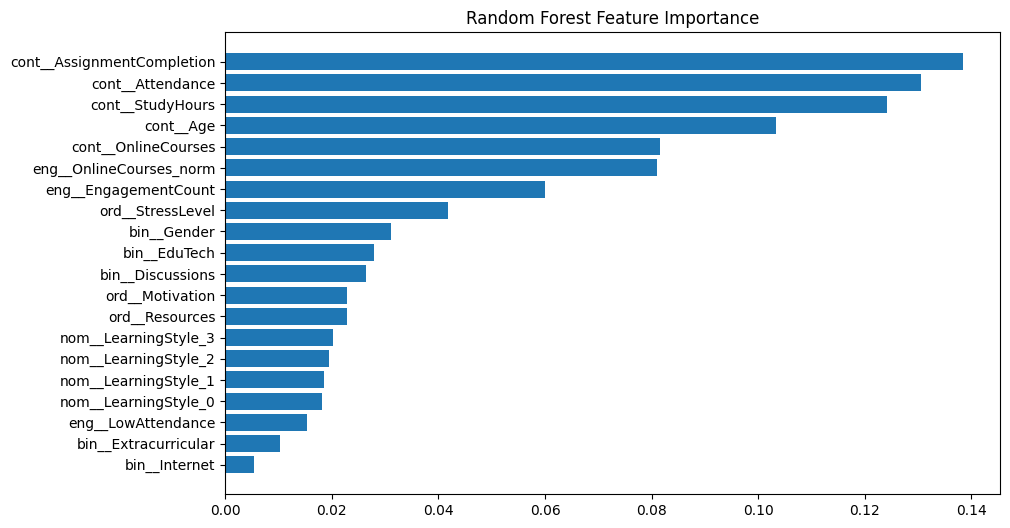

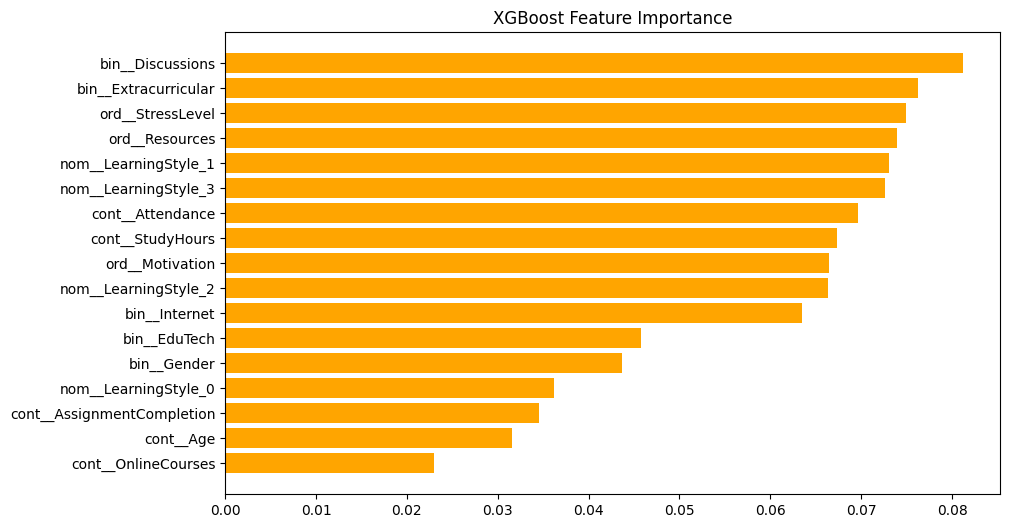


Random Forest Feature Importances:
cont__AssignmentCompletion: 0.1385
cont__Attendance: 0.1306
cont__StudyHours: 0.1242
cont__Age: 0.1034
cont__OnlineCourses: 0.0815
eng__OnlineCourses_norm: 0.0810
eng__EngagementCount: 0.0601
ord__StressLevel: 0.0418
bin__Gender: 0.0311
bin__EduTech: 0.0280
bin__Discussions: 0.0265
ord__Motivation: 0.0229
ord__Resources: 0.0229
nom__LearningStyle_3: 0.0202
nom__LearningStyle_2: 0.0194
nom__LearningStyle_1: 0.0186
nom__LearningStyle_0: 0.0182
eng__LowAttendance: 0.0153
bin__Extracurricular: 0.0103
bin__Internet: 0.0055


In [28]:
# -------------------------
# 15. MODEL INTERPRETABILITY
# -------------------------
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

# -------------------------
# Feature Importance
# -------------------------
# Random Forest
rf_importances = rf_model.feature_importances_
rf_sorted_idx = rf_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_sorted_idx)), rf_importances[rf_sorted_idx], align='center')
plt.yticks(range(len(rf_sorted_idx)), feature_names[rf_sorted_idx])
plt.title("Random Forest Feature Importance")
plt.show()

# XGBoost plot and table
xgb_importances = xgb_model.feature_importances_
xgb_sorted_idx = xgb_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_sorted_idx)), xgb_importances[xgb_sorted_idx], align='center', color='orange')
plt.yticks(range(len(xgb_sorted_idx)), feature_names[xgb_sorted_idx])
plt.title("XGBoost Feature Importance")
plt.show()


# print table of RF feature importances
print("\nRandom Forest Feature Importances:")
for idx in rf_sorted_idx[::-1]:
    print(f"{feature_names[idx]}: {rf_importances[idx]:.4f}")



# Final Comments and Reflections

## Overview

This notebook explored student performance prediction through a comprehensive analytical pipeline encompassing dimensionality reduction, unsupervised clustering, and supervised classification. The primary objective was to practice clustering, visualization, and dimensionality reduction techniques while carefully managing potential data leakage in an educational dataset where `ExamScore` served as a direct proxy (or possibly the raw input) for `FinalGrade`.

## Key Challenges

The most critical challenge encountered was **data leakage prevention**. The strong relationship between `ExamScore` and `FinalGrade` necessitated the complete exclusion of `ExamScore` from all modeling pipelines, as its inclusion would have resulted in artificially inflated performance metrics that would not generalize to real-world prediction scenarios where exam scores are not available a priori.

Additionally, target encoding required careful consideration. The original `FinalGrade` encoding (0=Fail, 1=Pass/C, 2=Good/B, 3=Great/A) was reversed to preserve ordinal relationships in a more intuitive manner, ensuring that higher numerical values corresponded to better academic outcomes.

## Notable Insights

### Cluster Personas and Performance Relationships

One of the most intriguing findings emerged from the cluster persona analysis. Contrary to intuitive expectations, clusters characterized by high study effort, strong attendance, and engagement metrics did not always correspond to superior `FinalGrade` outcomes. This suggests that:

1. **Study behaviors may not be uniformly effective** across all student contexts
2. **Latent factors** such as learning style compatibility, resource quality, or stress management may moderate the relationship between effort and performance
3. **Clustering based on behavioral features** captures student archetypes that transcend simple effort-outcome relationships

This non-linear relationship between study patterns and academic success underscores the complexity of educational outcomes and highlights the value of unsupervised learning techniques in revealing hidden student subpopulations.

### Model Performance Observations

The baseline **Random Forest classifier achieved approximately 92% accuracy**, establishing a strong benchmark. However, several subsequent modeling attempts yielded unexpected results:

- **Hyperparameter tuning** of Random Forest paradoxically decreased performance by ~4%, suggesting the baseline configuration was already near-optimal or that tuning introduced overfitting to the validation folds
- **Ordinal-aware models** (ordinal logistic regression and ordinal XGBoost) performed poorly (25-35% accuracy), indicating that treating `FinalGrade` as a strict ordinal target may have introduced excessive constraints that limited model flexibility
- **Ensemble methods** (voting classifier) matched but did not exceed baseline Random Forest performance, suggesting diminishing returns from model combination in this particular dataset

### Feature Importance Analysis

Feature importance rankings differed notably between XGBoost and Random Forest:

- **XGBoost** prioritized behavioral engagement features (`Discussions`, `Extracurricular`) and ordinal factors (`StressLevel`, `Resources`)
- **Random Forest** emphasized continuous academic metrics (`AssignmentCompletion`, `Attendance`, `StudyHours`)

Both models agreed that `Age` and `OnlineCourses` held moderate predictive value, while demographic features (`Gender`) and certain learning styles contributed less to prediction accuracy.

## Limitations

1. **Sample size and generalizability**: Results are specific to this dataset and may not generalize to other educational contexts
2. **Feature engineering scope**: Additional domain-specific features (e.g., prior academic history, socioeconomic indicators) could enhance model performance
3. **Temporal dynamics**: Cross-sectional data cannot capture learning trajectory changes over time
4. **Ordinal modeling**: The poor performance of ordinal-aware methods warrants further investigation into alternative formulations or regularization strategies

## Future Directions

Based on the findings and limitations of this analysis, several promising extensions could be pursued:

1. **Advanced ensemble techniques**: Explore stacking or boosting methods with diverse base learners to capture complementary prediction patterns
2. **Deep learning approaches**: Investigate neural network architectures (e.g., TabNet, entity embeddings) that can learn complex non-linear interactions
3. **Cluster-specific modeling**: Train separate models for each identified student persona, potentially improving performance through specialized prediction strategies
4. **Causal inference**: Apply causal discovery methods to distinguish correlation from causation in feature-outcome relationships
5. **Explainability enhancement**: Implement SHAP values or LIME to provide instance-level explanations for individual student predictions
6. **Temporal extension**: If longitudinal data becomes available, time-series or sequence models could capture learning trajectory dynamics
7. **Ordinal loss functions**: Experiment with custom loss functions that penalize misclassifications proportional to ordinal distance while maintaining model flexibility

## Conclusion

This notebook demonstrates that student performance prediction is a nuanced task where standard supervised learning approaches can achieve strong results, but where deeper insights emerge from combining multiple analytical paradigms. The disconnect between study effort and performance outcomes revealed through clustering analysis suggests that educational interventions should be personalized based on student archetypes rather than applied uniformly. While the baseline Random Forest provided excellent predictive performance, the exploration of alternative modeling strategies yielded valuable lessons about the trade-offs between model complexity, interpretability, and predictive accuracy in educational data science.